In [29]:
!pip install ultralytics

In [30]:
!unzip /content/wafer_data.zip -d /content


Archive:  /content/wafer_data.zip
replace /content/wafer_data.yaml? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [31]:
import os

def convert_folder(folder):
    label_dir = f"/content/{folder}/labels"

    for file in os.listdir(label_dir):
        path = os.path.join(label_dir, file)

        with open(path, "r") as f:
            lines = f.readlines()

        new_lines = []

        for line in lines:
            parts = list(map(float, line.split()))

            # Already segmentation → keep as is
            if len(parts) > 5:
                new_lines.append(line)
                continue

            # Detection → convert
            if len(parts) == 5:
                cls, xc, yc, w, h = parts

                if w <= 1e-6 or h <= 1e-6:
                    continue

                x1 = max(0, min(1, xc - w/2))
                y1 = max(0, min(1, yc - h/2))
                x2 = max(0, min(1, xc + w/2))
                y2 = max(0, min(1, yc - h/2))
                x3 = max(0, min(1, xc + w/2))
                y3 = max(0, min(1, yc + h/2))
                x4 = max(0, min(1, xc - w/2))
                y4 = max(0, min(1, yc + h/2))

                new_lines.append(
                    f"{int(cls)} {x1} {y1} {x2} {y2} {x3} {y3} {x4} {y4}\n"
                )

        with open(path, "w") as f:
            f.writelines(new_lines)


for split in ["train", "valid", "test"]:
    convert_folder(split)

print("Conversion complete!")


Conversion complete!


In [32]:
!rm -f /content/*/labels.cache


In [33]:
# from ultralytics import YOLO

# model = YOLO("yolo26n.pt")

# results = model.train(data="/content/wafer/wafer_data.yaml", epochs=100, imgsz=640)

from ultralytics import YOLO

# Load YOLO segmentation model
model = YOLO("yolo26n-seg.pt")

# Train segmentation
results = model.train(
    data="/content/wafer_data.yaml",
    epochs=100,
    imgsz=640,
    task="segment"
)



Ultralytics 8.4.14 🚀 Python-3.12.12 torch-2.9.0+cu128 CUDA:0 (Tesla T4, 14913MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/wafer_data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo26n-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=train6, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective

In [34]:
# # Load a model
# # model = YOLO("yolo26n.pt")  # load an official model
# model = YOLO("/content/runs/detect/train3/weights/best.pt")  # load a custom model

# # Predict with the model
# results = model("/content/wafer/valid/images/die_-8-5-_subdie_4_pullouts_1_png.rf.21d93bd228384436b3d223337e892276.jpg", conf=0.2, save=True)  # predict on an image

# # Access the results
# for result in results:
#     xywh = result.boxes.xywh  # center-x, center-y, width, height
#     xywhn = result.boxes.xywhn  # normalized
#     xyxy = result.boxes.xyxy  # top-left-x, top-left-y, bottom-right-x, bottom-right-y
#     xyxyn = result.boxes.xyxyn  # normalized
#     names = [result.names[cls.item()] for cls in result.boxes.cls.int()]  # class name of each box
#     confs = result.boxes.conf  # confidence score of each box
#     result.show()
#     result.save(filename="result.jpg")


image 1/1 /content/valid/images/seg_die_-2-5-_subdie_1_dut_2_png.rf.0e0b2571b4369a6207dcafcf87656f41.jpg: 640x640 3 Dies, 4 Pad_1s, 33 Pad_2s, 11.7ms
Speed: 3.1ms preprocess, 11.7ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/runs/segment/predict4


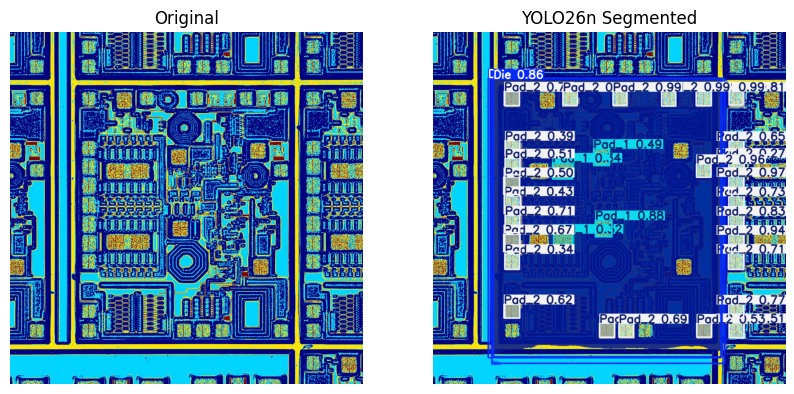

In [35]:
from ultralytics import YOLO

# Load your trained segmentation model
model = YOLO("/content/runs/segment/train5/weights/best.pt")

results = model.predict(
    source="/content/valid/images/seg_die_-2-5-_subdie_1_dut_2_png.rf.0e0b2571b4369a6207dcafcf87656f41.jpg",  # your image path
    imgsz=640,
    save=True  # saves output images
)

import matplotlib.pyplot as plt
import cv2

orig = cv2.imread("/content/valid/images/seg_die_-2-5-_subdie_1_dut_2_png.rf.0e0b2571b4369a6207dcafcf87656f41.jpg")
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)

seg = results[0].plot()
seg = cv2.cvtColor(seg, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("Original")
plt.imshow(orig)
plt.axis("off")

plt.subplot(1,2,2)
plt.title("YOLO26n Segmented")
plt.imshow(seg)
plt.axis("off")

plt.show()


In [36]:
!pip install -U segment-anything


In [37]:
# from ultralytics.data.annotator import auto_annotate

# auto_annotate(data="/content/wafer/valid/images/die_-8-5-_subdie_4_pullouts_1_png.rf.21d93bd228384436b3d223337e892276.jpg", det_model="/content/runs/detect/train3/weights/best.pt", sam_model='sam_b.pt')


In [38]:
import cv2
import torch
import numpy as np
import plotly.graph_objects as go

from segment_anything import sam_model_registry, SamAutomaticMaskGenerator


In [39]:
# !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth -O /content/sam_b.pt
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth -O /content/sam_vit_b.pt


In [40]:
!ls -lh /content/sam_vit_b.pt


-rw-r--r-- 1 root root 358M Apr  4  2023 /content/sam_vit_b.pt


Number of segments detected: 179


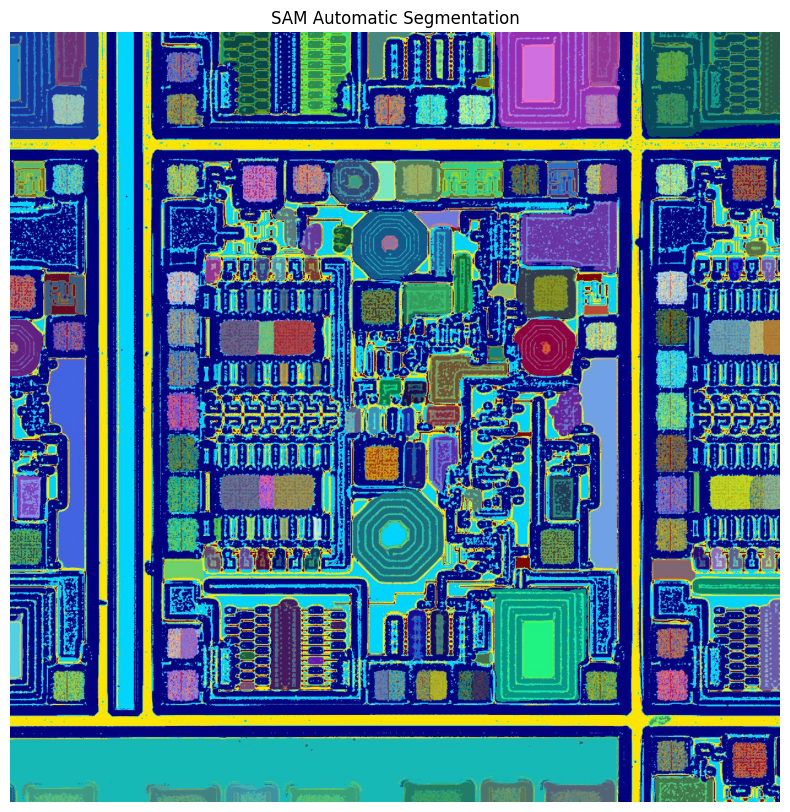

In [41]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt

from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

# ---------------------------
# Load image
# ---------------------------
image_path = "/content/valid/images/seg_die_-2-5-_subdie_1_dut_2_png.rf.0e0b2571b4369a6207dcafcf87656f41.jpg"

image = cv2.imread(image_path)

if image is None:
    raise ValueError("Image not found. Check path!")

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# ---------------------------
# Load SAM model
# ---------------------------
sam_checkpoint = "/content/sam_vit_b.pt"
model_type = "vit_b"   # must be vit_b / vit_l / vit_h

device = "cuda" if torch.cuda.is_available() else "cpu"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

# ---------------------------
# Automatic mask generator
# ---------------------------
mask_generator = SamAutomaticMaskGenerator(
    sam,
    points_per_side=32,  # increase for better segmentation
    pred_iou_thresh=0.88,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100
)

masks = mask_generator.generate(image)

print(f"Number of segments detected: {len(masks)}")

# ---------------------------
# Overlay masks
# ---------------------------
overlay = image.copy()

for mask in masks:
    seg = mask["segmentation"]

    color = np.random.randint(0, 255, 3)
    overlay[seg] = (0.4 * overlay[seg] + 0.6 * color).astype(np.uint8)

# ---------------------------
# Show with matplotlib
# ---------------------------
plt.figure(figsize=(10, 10))
plt.imshow(overlay)
plt.axis("off")
plt.title("SAM Automatic Segmentation")
plt.show()


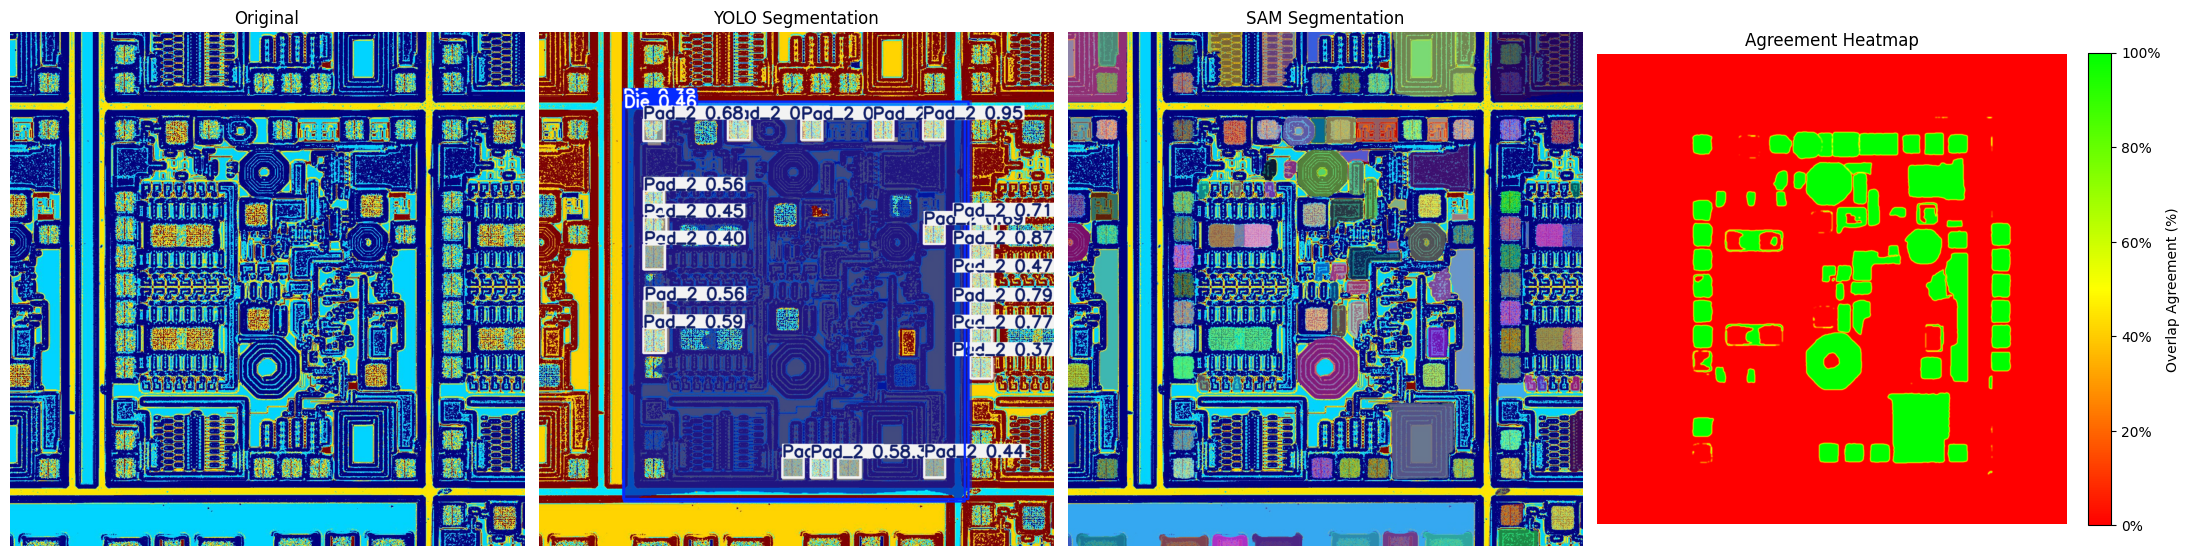

In [47]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from ultralytics import YOLO
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

# -------------------------------------------------
# Paths
# -------------------------------------------------
image_path = "/content/valid/images/seg_die_-2-5-_subdie_1_dut_2_png.rf.0e0b2571b4369a6207dcafcf87656f41.jpg"
yolo_model_path = "/content/runs/segment/train5/weights/best.pt"
sam_checkpoint = "/content/sam_vit_b.pt"

# -------------------------------------------------
# Load image
# -------------------------------------------------
orig = cv2.imread(image_path)
if orig is None:
    raise ValueError("Image not found. Check path!")

orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
H, W = orig.shape[:2]

# -------------------------------------------------
# YOLO segmentation
# -------------------------------------------------
yolo = YOLO(yolo_model_path)
results = yolo.predict(source=orig, imgsz=640, verbose=False)

yolo_overlay = results[0].plot()
yolo_overlay = cv2.cvtColor(yolo_overlay, cv2.COLOR_BGR2RGB)

# YOLO mask
yolo_mask = np.zeros((H, W), dtype=np.float32)

if results[0].masks is not None:
    masks = results[0].masks.data.cpu().numpy()
    for m in masks:
        m = cv2.resize(m, (W, H))
        yolo_mask = np.maximum(yolo_mask, m)

yolo_mask = (yolo_mask > 0.5).astype(np.float32)

# -------------------------------------------------
# SAM segmentation
# -------------------------------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"

sam = sam_model_registry["vit_b"](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(
    sam,
    points_per_side=32,
    pred_iou_thresh=0.88,
    stability_score_thresh=0.92,
)

sam_masks = mask_generator.generate(orig)

sam_overlay = orig.copy()
sam_mask = np.zeros((H, W), dtype=np.float32)

for m in sam_masks:
    seg = m["segmentation"]
    sam_mask[seg] = 1.0

    color = np.random.randint(0, 255, 3)
    sam_overlay[seg] = (0.4 * sam_overlay[seg] + 0.6 * color).astype(np.uint8)

# -------------------------------------------------
# Agreement heatmap (0 → 1)
# -------------------------------------------------
agreement = yolo_mask * sam_mask
agreement = cv2.GaussianBlur(agreement, (7, 7), 0)

# Red → Yellow → Green colormap
heatmap_cmap = LinearSegmentedColormap.from_list(
    "agreement",
    [(1, 0, 0), (1, 1, 0), (0, 1, 0)],
    N=256
)

# -------------------------------------------------
# Display results
# -------------------------------------------------
plt.figure(figsize=(22, 6))

plt.subplot(1, 4, 1)
plt.imshow(orig)
plt.title("Original")
plt.axis("off")

plt.subplot(1, 4, 2)
plt.imshow(yolo_overlay)
plt.title("YOLO Segmentation")
plt.axis("off")

plt.subplot(1, 4, 3)
plt.imshow(sam_overlay)
plt.title("SAM Segmentation")
plt.axis("off")

plt.subplot(1, 4, 4)
im = plt.imshow(agreement, cmap=heatmap_cmap, vmin=0, vmax=1)
plt.title("Agreement Heatmap")
plt.axis("off")

cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
cbar.set_label("Overlap Agreement (%)")

ticks = np.linspace(0, 1, 6)
cbar.set_ticks(ticks)
cbar.set_ticklabels([f"{int(t*100)}%" for t in ticks])

plt.tight_layout()
plt.show()


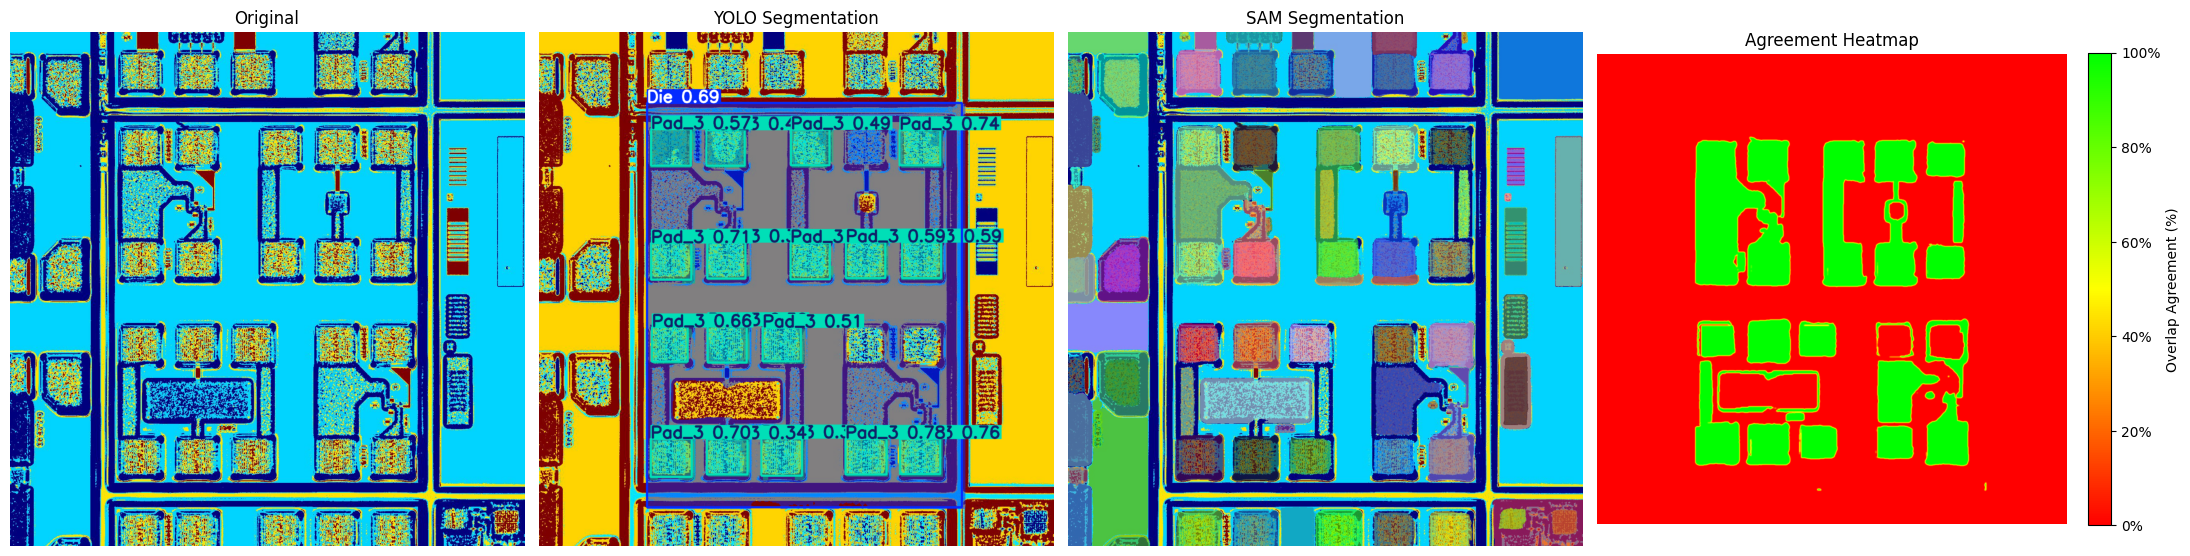

In [48]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from ultralytics import YOLO
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

# -------------------------------------------------
# Paths
# -------------------------------------------------
image_path = "/content/test/images/seg_die_-1-2-_subdie_5_pullouts_2_png.rf.8e1806162ffdc708746526c9082c974d.jpg"
yolo_model_path = "/content/runs/segment/train5/weights/best.pt"
sam_checkpoint = "/content/sam_vit_b.pt"

# -------------------------------------------------
# Load image
# -------------------------------------------------
orig = cv2.imread(image_path)
if orig is None:
    raise ValueError("Image not found. Check path!")

orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
H, W = orig.shape[:2]

# -------------------------------------------------
# YOLO segmentation
# -------------------------------------------------
yolo = YOLO(yolo_model_path)
results = yolo.predict(source=orig, imgsz=640, verbose=False)

yolo_overlay = results[0].plot()
yolo_overlay = cv2.cvtColor(yolo_overlay, cv2.COLOR_BGR2RGB)

# YOLO mask
yolo_mask = np.zeros((H, W), dtype=np.float32)

if results[0].masks is not None:
    masks = results[0].masks.data.cpu().numpy()
    for m in masks:
        m = cv2.resize(m, (W, H))
        yolo_mask = np.maximum(yolo_mask, m)

yolo_mask = (yolo_mask > 0.5).astype(np.float32)

# -------------------------------------------------
# SAM segmentation
# -------------------------------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"

sam = sam_model_registry["vit_b"](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(
    sam,
    points_per_side=32,
    pred_iou_thresh=0.88,
    stability_score_thresh=0.92,
)

sam_masks = mask_generator.generate(orig)

sam_overlay = orig.copy()
sam_mask = np.zeros((H, W), dtype=np.float32)

for m in sam_masks:
    seg = m["segmentation"]
    sam_mask[seg] = 1.0

    color = np.random.randint(0, 255, 3)
    sam_overlay[seg] = (0.4 * sam_overlay[seg] + 0.6 * color).astype(np.uint8)

# -------------------------------------------------
# Agreement heatmap (0 → 1)
# -------------------------------------------------
agreement = yolo_mask * sam_mask
agreement = cv2.GaussianBlur(agreement, (7, 7), 0)

# Red → Yellow → Green colormap
heatmap_cmap = LinearSegmentedColormap.from_list(
    "agreement",
    [(1, 0, 0), (1, 1, 0), (0, 1, 0)],
    N=256
)

# -------------------------------------------------
# Display results
# -------------------------------------------------
plt.figure(figsize=(22, 6))

plt.subplot(1, 4, 1)
plt.imshow(orig)
plt.title("Original")
plt.axis("off")

plt.subplot(1, 4, 2)
plt.imshow(yolo_overlay)
plt.title("YOLO Segmentation")
plt.axis("off")

plt.subplot(1, 4, 3)
plt.imshow(sam_overlay)
plt.title("SAM Segmentation")
plt.axis("off")

plt.subplot(1, 4, 4)
im = plt.imshow(agreement, cmap=heatmap_cmap, vmin=0, vmax=1)
plt.title("Agreement Heatmap")
plt.axis("off")

cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
cbar.set_label("Overlap Agreement (%)")

ticks = np.linspace(0, 1, 6)
cbar.set_ticks(ticks)
cbar.set_ticklabels([f"{int(t*100)}%" for t in ticks])

plt.tight_layout()
plt.show()



image 1/1 /content/test/images/seg_die_-1-2-_subdie_5_pullouts_2_png.rf.8e1806162ffdc708746526c9082c974d.jpg: 640x640 2 Dies, 26 Pad_3s, 16.2ms
Speed: 4.6ms preprocess, 16.2ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)


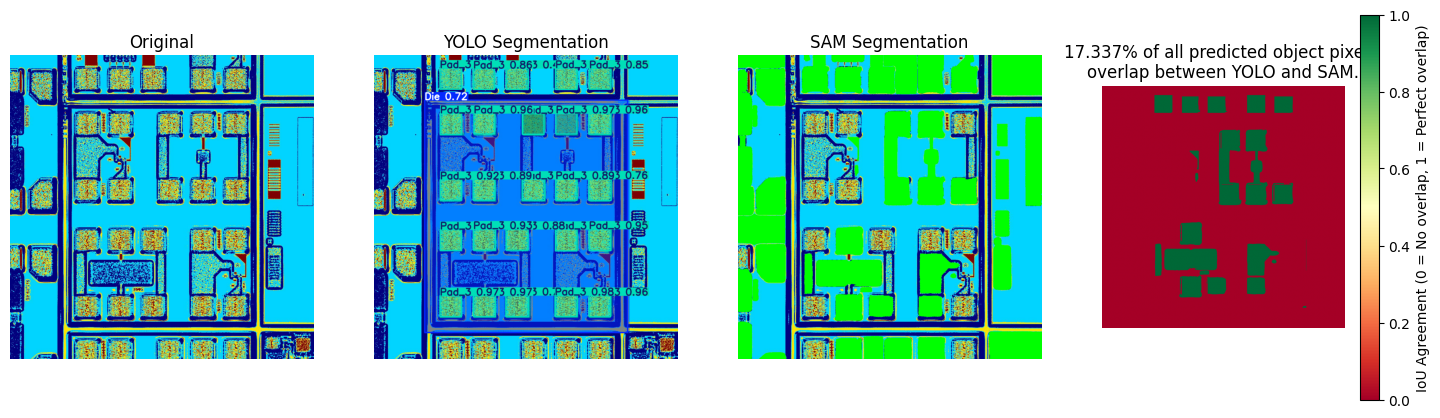

In [55]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

# ---------------------------
# Load image
# ---------------------------
image_path = "/content/test/images/seg_die_-1-2-_subdie_5_pullouts_2_png.rf.8e1806162ffdc708746526c9082c974d.jpg"

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
H, W = image.shape[:2]

# ---------------------------
# YOLO segmentation
# ---------------------------
yolo_model = YOLO("/content/runs/segment/train5/weights/best.pt")

# IMPORTANT: use image path so YOLO keeps original resolution
yolo_results = yolo_model.predict(source=image_path, imgsz=640)

yolo_mask = np.zeros((H, W), dtype=bool)

if yolo_results[0].masks is not None:
    for m in yolo_results[0].masks.data.cpu().numpy():

        # resize YOLO mask to original image size
        resized_mask = cv2.resize(
            m.astype(np.uint8),
            (W, H),
            interpolation=cv2.INTER_NEAREST
        ).astype(bool)

        yolo_mask |= resized_mask

yolo_vis = yolo_results[0].plot()
yolo_vis = cv2.cvtColor(yolo_vis, cv2.COLOR_BGR2RGB)

# ---------------------------
# SAM segmentation
# ---------------------------
sam_checkpoint = "/content/sam_vit_b.pt"
model_type = "vit_b"

device = "cuda" if torch.cuda.is_available() else "cpu"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)
sam_masks = mask_generator.generate(image)

sam_mask = np.zeros((H, W), dtype=bool)

for m in sam_masks:
    sam_mask |= m["segmentation"]

sam_overlay = image.copy()
sam_overlay[sam_mask] = [0, 255, 0]

# ---------------------------
# IoU agreement
# ---------------------------
intersection = np.logical_and(yolo_mask, sam_mask)
union = np.logical_or(yolo_mask, sam_mask)

iou_score = (intersection.sum() / (union.sum() + 1e-8))*100

# IoU heatmap
iou_map = np.zeros((H, W), dtype=float)
iou_map[union] = intersection[union].astype(float)

# ---------------------------
# Plot results
# ---------------------------
plt.figure(figsize=(18, 5))

plt.subplot(1, 4, 1)
plt.imshow(image)
plt.title("Original")
plt.axis("off")

plt.subplot(1, 4, 2)
plt.imshow(yolo_vis)
plt.title("YOLO Segmentation")
plt.axis("off")

plt.subplot(1, 4, 3)
plt.imshow(sam_overlay)
plt.title("SAM Segmentation")
plt.axis("off")

plt.subplot(1, 4, 4)
heat = plt.imshow(iou_map, cmap="RdYlGn", vmin=0, vmax=1)

# plt.title(f"IoU Agreement\nScore = {iou_score:.3f}")
plt.title(f"{iou_score:.3f}% of all predicted object pixels \noverlap between YOLO and SAM.")
plt.axis("off")

cbar = plt.colorbar(heat)
cbar.set_label("IoU Agreement (0 = No overlap, 1 = Perfect overlap)")

plt.show()



image 1/1 /content/valid/images/seg_die_-2-5-_subdie_1_dut_2_png.rf.0e0b2571b4369a6207dcafcf87656f41.jpg: 640x640 3 Dies, 4 Pad_1s, 33 Pad_2s, 11.9ms
Speed: 3.0ms preprocess, 11.9ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)


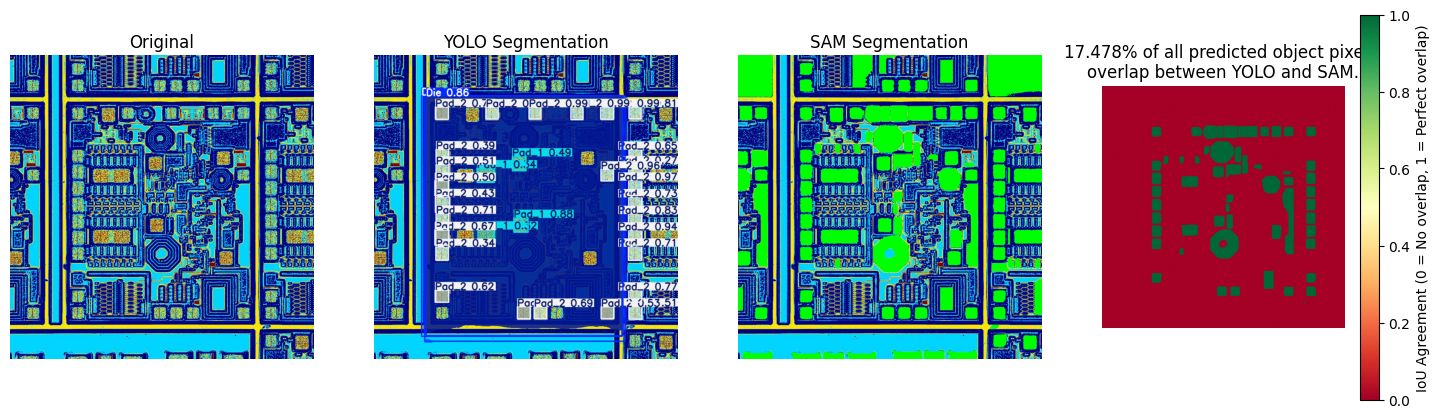

In [57]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

# ---------------------------
# Load image
# ---------------------------
image_path = "/content/valid/images/seg_die_-2-5-_subdie_1_dut_2_png.rf.0e0b2571b4369a6207dcafcf87656f41.jpg"

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
H, W = image.shape[:2]

# ---------------------------
# YOLO segmentation
# ---------------------------
yolo_model = YOLO("/content/runs/segment/train5/weights/best.pt")

# IMPORTANT: use image path so YOLO keeps original resolution
yolo_results = yolo_model.predict(source=image_path, imgsz=640)

yolo_mask = np.zeros((H, W), dtype=bool)

if yolo_results[0].masks is not None:
    for m in yolo_results[0].masks.data.cpu().numpy():

        # resize YOLO mask to original image size
        resized_mask = cv2.resize(
            m.astype(np.uint8),
            (W, H),
            interpolation=cv2.INTER_NEAREST
        ).astype(bool)

        yolo_mask |= resized_mask

yolo_vis = yolo_results[0].plot()
yolo_vis = cv2.cvtColor(yolo_vis, cv2.COLOR_BGR2RGB)

# ---------------------------
# SAM segmentation
# ---------------------------
sam_checkpoint = "/content/sam_vit_b.pt"
model_type = "vit_b"

device = "cuda" if torch.cuda.is_available() else "cpu"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)
sam_masks = mask_generator.generate(image)

sam_mask = np.zeros((H, W), dtype=bool)

for m in sam_masks:
    sam_mask |= m["segmentation"]

sam_overlay = image.copy()
sam_overlay[sam_mask] = [0, 255, 0]

# ---------------------------
# IoU agreement
# ---------------------------
intersection = np.logical_and(yolo_mask, sam_mask)
union = np.logical_or(yolo_mask, sam_mask)

iou_score = (intersection.sum() / (union.sum() + 1e-8))*100

# IoU heatmap
iou_map = np.zeros((H, W), dtype=float)
iou_map[union] = intersection[union].astype(float)

# ---------------------------
# Plot results
# ---------------------------
plt.figure(figsize=(18, 5))

plt.subplot(1, 4, 1)
plt.imshow(image)
plt.title("Original")
plt.axis("off")

plt.subplot(1, 4, 2)
plt.imshow(yolo_vis)
plt.title("YOLO Segmentation")
plt.axis("off")

plt.subplot(1, 4, 3)
plt.imshow(sam_overlay)
plt.title("SAM Segmentation")
plt.axis("off")

plt.subplot(1, 4, 4)
heat = plt.imshow(iou_map, cmap="RdYlGn", vmin=0, vmax=1)

# plt.title(f"IoU Agreement\nScore = {iou_score:.3f}")
plt.title(f"{iou_score:.3f}% of all predicted object pixels \noverlap between YOLO and SAM.")
plt.axis("off")

cbar = plt.colorbar(heat)
cbar.set_label("IoU Agreement (0 = No overlap, 1 = Perfect overlap)")

plt.show()


In [42]:
# # Load your trained YOLO model
# yolo = YOLO("/content/runs/detect/train3/weights/best.pt")

# # Load SAM
# sam = sam_model_registry["vit_b"](
#     checkpoint="/content/sam_b.pt"
# )
# sam.to("cuda" if torch.cuda.is_available() else "cpu")

# predictor = SamPredictor(sam)

# # Load Image
# img_path = "/content/wafer/test/images/seg_die_-2-5-_subdie_0_dut_1_png.rf.a572c3cbac600f3009db4406e5c9b893.jpg"

# img_bgr = cv2.imread(img_path)
# img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

# h, w, _ = img_rgb.shape
# predictor.set_image(img_rgb)

# # YOLO detection
# results = yolo(img_rgb)[0]

# boxes = results.boxes.xyxy.cpu().numpy()
# classes = results.boxes.cls.cpu().numpy().astype(int)
# names = yolo.names

# # Pass YOLO boxes to SAM Segmentation
# masks = []

# for box in boxes:
#     mask, _, _ = predictor.predict(
#         box=box,
#         multimask_output=False
#     )
#     masks.append(mask[0])

# import matplotlib.pyplot as plt
# from matplotlib.patches import Patch

# # Fixed colors per class (RGB 0–1)
# CLASS_COLORS = {
#     0: (1.0, 0.0, 0.0),   # Die
#     1: (0.0, 1.0, 0.0),   # Pad_1
#     2: (0.0, 0.0, 1.0),   # Pad_2
#     3: (1.0, 1.0, 0.0),   # Pad_3
# }

# fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# # -------------------------------
# # Subplot 1: Original image
# # -------------------------------
# axes[0].imshow(img_rgb)
# axes[0].set_title("Original Image")
# axes[0].axis("off")

# # -------------------------------
# # Subplot 2: Segmentation overlay
# # -------------------------------
# axes[1].imshow(img_rgb)
# axes[1].set_title("YOLO → SAM Segmentation")
# axes[1].axis("off")

# legend_patches = {}
# alpha = 0.45

# for mask, cls in zip(masks, classes):
#     color = CLASS_COLORS.get(cls, (1, 1, 1))

#     rgba = np.zeros((*mask.shape, 4))
#     rgba[..., :3] = color
#     rgba[..., 3] = mask * alpha   # transparent outside mask

#     axes[1].imshow(rgba)

#     if cls not in legend_patches:
#         legend_patches[cls] = Patch(
#             facecolor=color,
#             label=names[cls]
#         )

# # Legend
# axes[1].legend(
#     handles=list(legend_patches.values()),
#     loc="upper right"
# )

# plt.tight_layout()
# plt.show()
